In [3]:
!pip install -q lightgbm xgboost scikit-learn pandas numpy matplotlib


In [1]:
from google.colab import files

uploaded = files.upload()  # chọn file log_prepared.csv từ máy



Saving log_prepared.csv to log_prepared.csv


In [2]:
from google.colab import drive
# drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/big-data/log_prepared.csv"


# IMPORT LIBRARY

In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import joblib
import os
import json


# DATA PROCESSING

## READ DATA


In [5]:
# Đường dẫn tới file csv dữ liệu
CSV_PATH = "/content/log_prepared.csv"

# Đọc dữ liệu thành DataFrame
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print(df.head())
print(df["label_index"].value_counts())

Shape: (575061, 31)
                    BlockId  E1  E2  E3  E4  E5  E6  E7  E8  E9  ...  E21  \
0  blk_-1001138135617662562   0   0   8   4   3   0   0   0   3  ...    3   
1  blk_-1005590426013980840   0   0   0   0   3   0   0   0   3  ...    3   
2   blk_-102130907746974051   0   0   0   0   3   0   0   0   3  ...    3   
3  blk_-1024067452279512003   0   0   0   0   3   0   0   0   3  ...    0   
4  blk_-1027487181718073118   0   0   0   0   3   0   0   0   3  ...    0   

   E22  E23  E24  E25  E26  E27  E28  E29  label_index  
0    1    3    0    0    3    0    0    0            0  
1    1    3    0    0    3    0    0    0            0  
2    1    3    0    0    3    0    0    0            0  
3    1    0    0    0    3    0    0    0            0  
4    1    0    0    0    3    0    0    0            0  

[5 rows x 31 columns]
label_index
0    558223
1     16838
Name: count, dtype: int64


## DATA PREPARING

In [6]:
# Tách feature và label , bỏ cột BlockId
y = df["label_index"]
X = df.drop(columns=["label_index", "BlockId"])

# loại cột hằng (variance = 0)
nunique = X.nunique()
const_cols = nunique[nunique == 1].index.tolist()
print("Constant columns:", const_cols)

X = X.drop(columns=const_cols)

# Ép kiểu cho nhẹ
X = X.astype("float32")

print("Final features:", X.columns.tolist())
print("Số feature còn lại:", X.shape[1])

Constant columns: ['E22']
Final features: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29']
Số feature còn lại: 28


In [7]:
# Chia các tập train-valid-test với tham số stratify giúp cân bằng tỷ lệ label ở mỗi tập
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train size:", X_train.shape, "Pos ratio:", y_train.mean())
print("Valid size:", X_valid.shape, "Pos ratio:", y_valid.mean())
print("Test  size:", X_test.shape,  "Pos ratio:", y_test.mean())

Train size: (345036, 28) Pos ratio: 0.029281002562051496
Valid size: (115012, 28) Pos ratio: 0.02927520606545404
Test  size: (115013, 28) Pos ratio: 0.029283646196516914


# MODEL

In [8]:
# tỷ lệ 0:1 ~ 33:1 -> weight ~ 33
pos_weight = 33.0  # tỷ lệ mất cân bằng ~33:1

# Khởi tạo mô hình với trọng số cho label 1 là 33
lgb_model = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=3000, # Số cây tối đa là 3000
    learning_rate=0.05,
    num_leaves=63,
    max_depth=6,
    min_data_in_leaf=200,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=pos_weight,
    n_jobs=-1,
    random_state=42
)

callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=10000)
]

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=["train", "valid"],
    eval_metric=["auc", "average_precision"],
    callbacks=callbacks
)

print("Best iteration:", lgb_model.best_iteration_)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 10103, number of negative: 334933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 345036, number of used features: 18
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029281 -> initscore=-3.501098
[LightGBM] [Info] Start training from score -3.501098
[LightGBM] [Warning] No further splits with positive gain, best gain:

# EVALUATIE MODEL


In [9]:
y_valid_proba = lgb_model.predict_proba(X_valid)[:, 1]

roc = roc_auc_score(y_valid, y_valid_proba)
pr_auc = average_precision_score(y_valid, y_valid_proba)

print("=== Validation metrics ===")
print("ROC-AUC:", roc)
print("PR-AUC :", pr_auc)

# Tìm threshold tốt nhất theo F1
best_thr = 0.5
best_f1 = -1

for thr in np.linspace(0.01, 0.99, 99):
    y_pred = (y_valid_proba >= thr).astype(int)
    f1 = f1_score(y_valid, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("\nBest threshold on valid:", best_thr)
print("Best F1 on valid      :", best_f1)

y_best = (y_valid_proba >= best_thr).astype(int)
print("Precision at best thr:", precision_score(y_valid, y_best))
print("Recall at best thr   :", recall_score(y_valid, y_best))

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
=== Validation metrics ===
ROC-AUC: 0.9999543333279729
PR-AUC : 0.998054779094274

Best threshold on valid: 0.8300000000000001
Best F1 on valid      : 0.9942316225410442
Precision at best thr: 0.9902769593400118
Recall at best thr   : 0.9982179982179982


In [11]:
y_test_proba = lgb_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_thr).astype(int)

print("\n=== Test metrics ===")
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("Test PR-AUC :", average_precision_score(y_test, y_test_proba))

print("\nConfusion matrix (test):\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification report (test):\n", classification_report(y_test, y_test_pred, digits=4))

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200

=== Test metrics ===
Test ROC-AUC: 0.9999976051828684
Test PR-AUC : 0.9999125410082585

Confusion matrix (test):
 [[111637      8]
 [     8   3360]]

Classification report (test):
               precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999    111645
           1     0.9976    0.9976    0.9976      3368

    accuracy                         0.9999    115013
   macro avg     0.9988    0.9988    0.9988    115013
weighted avg     0.9999    0.9999    0.9999    115013



# VISUALIZATION


Top 20 feature importance:
   feature  importance
24     E26         209
2       E3         186
20     E21         121
19     E20         117
25     E27         117
17     E18         112
12     E13         110
8       E9         104
4       E5          82
26     E28          73
3       E4          56
21     E23          54
1       E2          48
5       E6          17
23     E25          14
10     E11          11
15     E16           6
6       E7           1
7       E8           0
0       E1           0


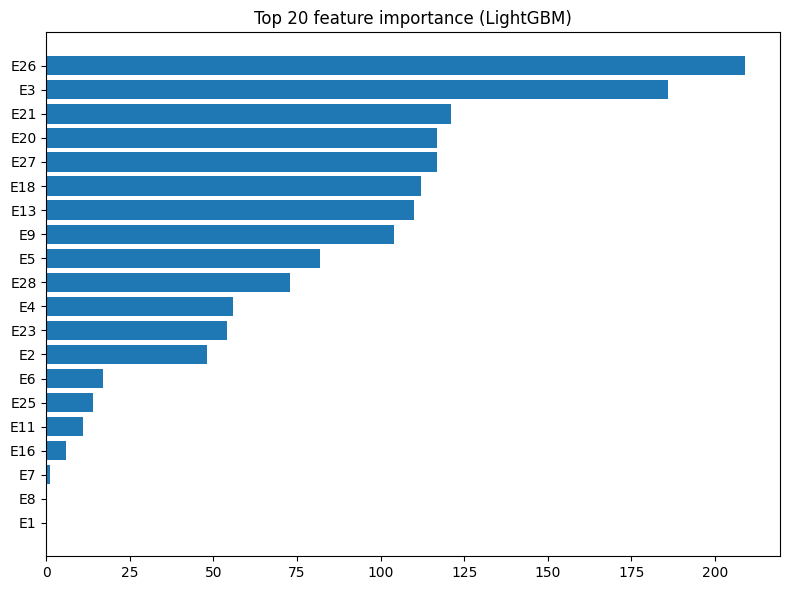

In [10]:
# Các feature có ảnh hưởng nhiều tới model
feature_importances = lgb_model.feature_importances_
feat_names = X_train.columns

imp = (
    pd.DataFrame({
        "feature": feat_names,
        "importance": feature_importances
    })
    .sort_values("importance", ascending=False)
)

print("\nTop 20 feature importance:")
print(imp.head(20))

plt.figure(figsize=(8, 6))
imp_head = imp.head(20)
plt.barh(imp_head["feature"], imp_head["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 feature importance (LightGBM)")
plt.tight_layout()
plt.show()


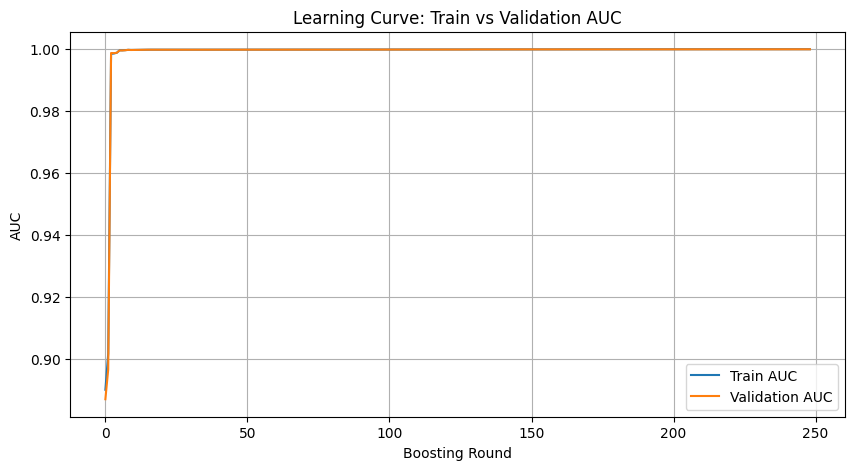

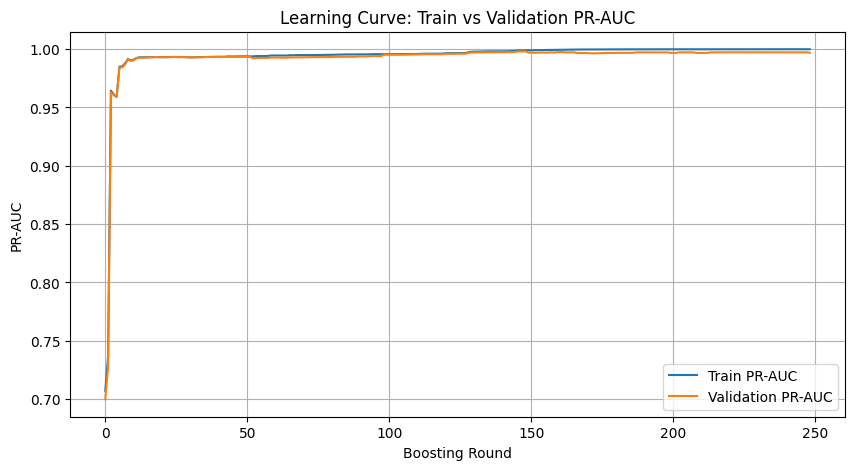

In [11]:
import matplotlib.pyplot as plt

evals_result = lgb_model.evals_result_

# AUC
train_auc = evals_result["train"]["auc"]
valid_auc = evals_result["valid"]["auc"]

plt.figure(figsize=(10, 5))
plt.plot(train_auc, label="Train AUC")
plt.plot(valid_auc, label="Validation AUC")
plt.xlabel("Boosting Round")
plt.ylabel("AUC")
plt.title("Learning Curve: Train vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()

# PR-AUC (average_precision)
train_pr = evals_result["train"]["average_precision"]
valid_pr = evals_result["valid"]["average_precision"]

plt.figure(figsize=(10, 5))
plt.plot(train_pr, label="Train PR-AUC")
plt.plot(valid_pr, label="Validation PR-AUC")
plt.xlabel("Boosting Round")
plt.ylabel("PR-AUC")
plt.title("Learning Curve: Train vs Validation PR-AUC")
plt.legend()
plt.grid(True)
plt.show()


# MODEL DOWNLOAD

In [14]:
# Thư mục lưu artefact
os.makedirs("artifacts", exist_ok=True)

# 1) Lưu model LightGBM (sklearn wrapper)
model_path = "artifacts/lgb_hdfs_model.pkl"
joblib.dump(lgb_model, model_path)
print("Saved model to:", model_path)

Saved model to: artifacts/lgb_hdfs_model.pkl


In [15]:
feature_cols = X.columns.tolist()

meta = {
    "feature_cols": feature_cols,
    "const_cols": const_cols,
    "best_iteration": int(lgb_model.best_iteration_),
}

meta_path = "artifacts/lgb_hdfs_meta.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("Saved meta to:", meta_path)

Saved meta to: artifacts/lgb_hdfs_meta.json
